In [2]:
import numpy as np
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [40]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230120'
}

query = """
SELECT exp_group,
       user_id,
       countIf(action = 'view') views,
       countIf(action = 'like') likes,
       likes / views ctr
  FROM {db}.feed_actions
 WHERE toDate(time) BETWEEN '2023-01-01' AND '2023-01-07'
       AND exp_group IN (1, 2)
 GROUP BY exp_group,
          user_id
"""

df = pandahouse.read_clickhouse(query, connection=connection)

# Проверим, что все загрузилось как надо
print(df.head(5))

   exp_group  user_id  views  likes       ctr
0          1   109963     15      3  0.200000
1          1    26117    141     32  0.226950
2          1   138232     73     18  0.246575
3          1    26295    122     33  0.270492
4          1    18392     32      7  0.218750


<h4>Посмотрим, как распределения выглядят визуально, используя гистограммы</h4>

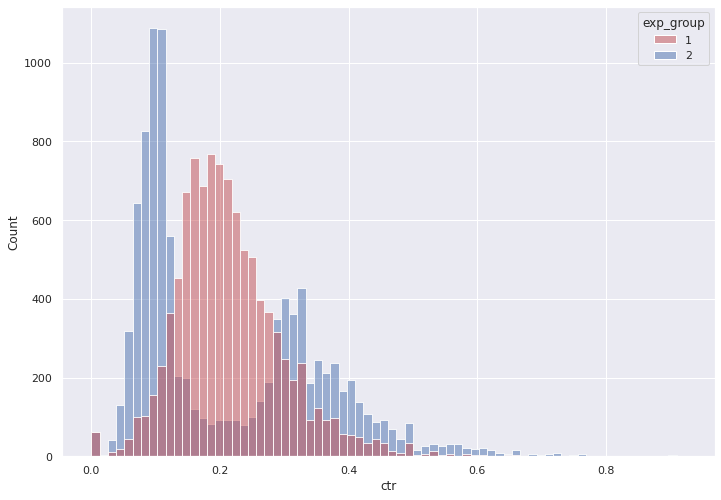

In [5]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data=df,
             x='ctr',
             hue='exp_group',
             palette=['r', 'b'],
             alpha=0.5,
             kde=False);

<h4>Как можно заметить, распределение контрольной группы похоже на нормальное распределение, когда распределение группы с новым алгоритмом является бимодальным. Проведем t-test</h4>

In [18]:
t_test_result = stats.ttest_ind(df[df.exp_group == 1].ctr,
                                df[df.exp_group == 2].ctr,
                                equal_var=False)

print(f't-статистика равна {t_test_result[0]:.2f}')
if t_test_result[1] <= 0.05:
    print(f'Значение p-value - {t_test_result[1]:.2f}, значит принимаем альтернативную гипотезу.')
else:
    print(f'Значение p-value - {t_test_result[1]:.2f}, значит мы не можем опровергнуть нулевую гипотезу.')

t-статистика равна 0.71
Значение p-value - 0.48, значит мы не можем опровергнуть нулевую гипотезу.


<h4>t-test не заметил разности между распределениями. Возможно, это произошло из-за того, что среднее значение бимодального распределения оказалось рядом со средним значением контрольной группы. Теперь проведем тест Манна-Уитни.</h4>

In [19]:
mannwhitneyu_result = stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                                         df[df.exp_group == 2].ctr)

if mannwhitneyu_result[1] <= 0.05:
    print(f'Значение p-value - {mannwhitneyu_result[1]:.2f}, значит принимаем альтернативную гипотезу.')
else:
    print(f'Значение p-value - {mannwhitneyu_result[1]:.2f}, значит мы не можем опровергнуть нулевую гипотезу.')

Значение p-value - 0.00, значит принимаем альтернативную гипотезу.


<h4>Тест Манна-Уитни заметил разницу между двумя распределениями. Теперь проверим, что покажет t-test на сглаженном ctr</h4>

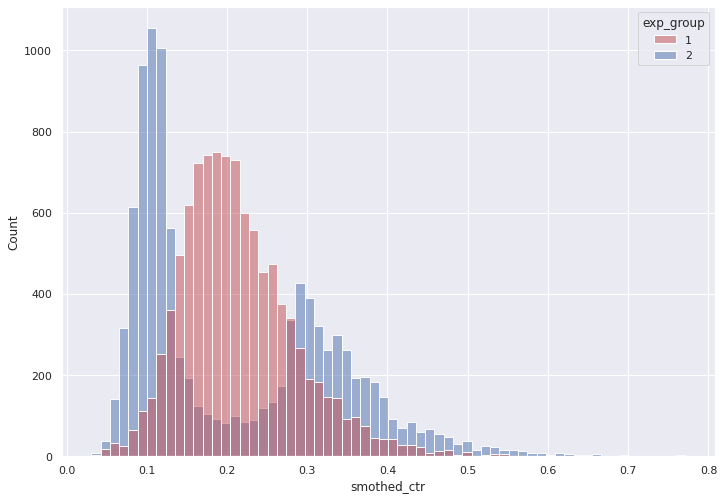

In [28]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(data=pd.concat([group1, group2]),
             x='smothed_ctr',
             hue='exp_group',
             palette=['r', 'b'],
             alpha=0.5,
             kde=False);

In [29]:
smoothed_t_test_result = stats.ttest_ind(group1.smothed_ctr,
                                         group2.smothed_ctr,
                                         equal_var=False)

print(f't-статистика равна {smoothed_t_test_result[0]:.2f}')
if smoothed_t_test_result[1] <= 0.05:
    print(f'Значение p-value - {smoothed_t_test_result[1]:.2f}, значит принимаем альтернативную гипотезу.')
else:
    print(f'Значение p-value - {smoothed_t_test_result[1]:.2f}, значит мы не можем опровергнуть нулевую гипотезу.')

t-статистика равна 2.28
Значение p-value - 0.02, значит принимаем альтернативную гипотезу.


<h4>На сглаженном ctr t-test видит разницу между двумя группами. Теперь проверим, что покажет Пуассоновский бутстреп</h4>

<AxesSubplot:ylabel='Count'>

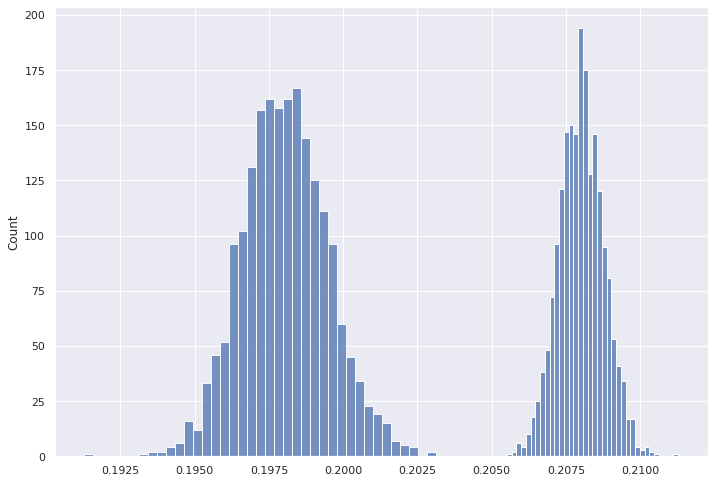

In [37]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

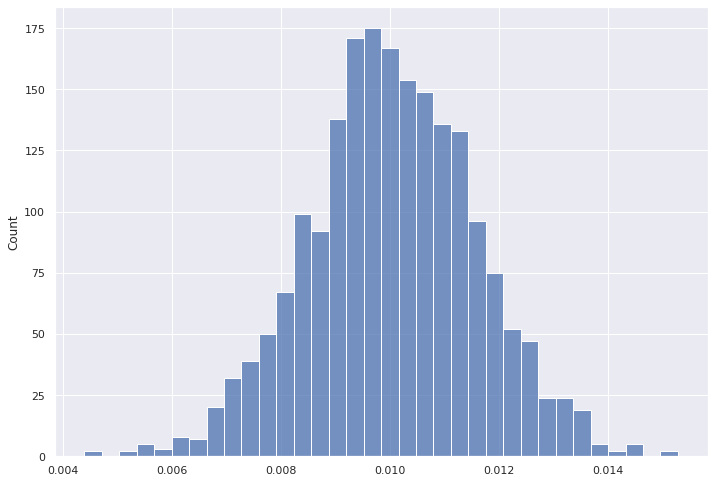

In [32]:
#Разница между глобальными CTR
sns.histplot(ctr1 - ctr2);

<h4>Пуассоновский бутстреп замечает разницу между двумя группами. Гистограммы не пересекаются друг с другом, а их разница явно показывает, что глобальный ctr второй группы больше, чем у первой. Теперь посмотрим, какой результат мы получим применив t-тест и тест Манна-Уитни поверх бакетного преобразования</h4>

In [41]:
# Разобъем пользователей по бакетам и найдем среднее значение каждого бакета
query = """
SELECT exp_group, bucket,
       SUM(likes) / SUM(views) as bucket_ctr,
       quantileExact(0.9)(ctr) as ctr9
  FROM (SELECT exp_group, 
               xxHash64(user_id) % 50 as bucket,
               user_id,
               sum(action = 'like') as likes,
               sum(action = 'view') as views,
               likes / views as ctr
          FROM {db}.feed_actions 
          WHERE toDate(time) BETWEEN '2023-01-01' AND '2023-01-07'
                AND exp_group IN (1, 2)
          GROUP BY exp_group,
                   bucket,
                   user_id)
   GROUP BY exp_group,
            bucket
"""

df2 = pandahouse.read_clickhouse(query, connection=connection)



In [43]:
# Тест Манна-Уитни
mannwhitneyu_bucket_result = stats.mannwhitneyu(df2[df2.exp_group == 1].bucket_ctr, 
                                                df2[df2.exp_group == 2].bucket_ctr, 
                                                alternative = 'two-sided')

if mannwhitneyu_bucket_result[1]:
    print(f'Значение p-value - {mannwhitneyu_bucket_result[1]:.2f}, значит принимаем альтернативную гипотезу.')
else:
    print(f'Значение p-value - {mannwhitneyu_bucket_result[1]:.2f}, значит мы не можем опровергнуть нулевую гипотезу.')

Значение p-value - 0.00, значит принимаем альтернативную гипотезу.


In [45]:
# t-test
t_test_bucket_result = stats.ttest_ind(df2[df2.exp_group == 1].bucket_ctr, 
                                       df2[df2.exp_group == 2].bucket_ctr, 
                                       equal_var=False)

if t_test_bucket_result[1]:
    print(f'Значение p-value - {t_test_bucket_result[1]:.2f}, значит принимаем альтернативную гипотезу.')
else:
    print(f'Значение p-value - {t_test_bucket_result[1]:.2f}, значит мы не можем опровергнуть нулевую гипотезу.')

Значение p-value - 0.00, значит принимаем альтернативную гипотезу.


<h4>t-тест и тест Манна-Уитни поверх бакетного преобразования заметили разницу между группами.</h4>

<h2>Вывод</h2>
<ol>
    <li>Все тесты, кроме обычного t-test показали, что ctr двух групп отличается друг от друга. Причина того, что t-test не сработал, связана с бимодальностью распределения группы с новым алгоритмом</li>
    <li>Бимодальность, вероятно, связана с тем, что новый алгоритм смог увеличить ctr только для определенной группы пользователей, а для остальных пользователей он, наоборот, уменьшил ctr.</li>
    <li>В данный момент не стоит раскатывать новый алгоритм на всех новых пользователей. Перед этим нужно разобраться, на какую группу он смог повлиять, и почему на остальных он не подействовал.</li>
</ol>
  